In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 671

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 19
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [5]:
dtrain_val = dataloader.Forcing_Data(
    "data/all_camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "data/all_camels_train.csv",
    record_length=2922,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "data/all_camels_val.csv",
    record_length=1095,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/all_camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [4]:
class Objective:
    def __init__(self, model_builder):
        self.model_builder = model_builder

    def objective(self, trial):

        # prepare early stopper
        early_stopper = training_fun.EarlyStopper(patience=PATIENCE, min_delta=0)

        # define model
        embedding, decoder = self.model_builder.define_model(trial)
        embedding, decoder = embedding.to(computing_device), decoder.to(
            computing_device
        )

        if compile_model:
            # pytorch2.0 new feature, complile model for fast training
            embedding, decoder = torch.compile(embedding), torch.compile(decoder)

        # define optimizers
        lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
        embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

        lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

        # define batch size
        batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
        batch_size = 2**batch_size_power

        # steps per epoch
        steps = round(N_CATCHMENTS * TRAIN_YEAR / batch_size)

        # train model
        for epoch in range(EPOCHS):

            # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
            # repeat TRAIN_YEAR times to finish an epoch
            decoder.train()
            embedding.train()

            for step in range(steps):

                decoder_optimizer.zero_grad()
                embedding_optimizer.zero_grad()

                # put the models into training mode
                decoder.train()
                embedding.train()

                # get training batch and pass to device
                (x_batch, y_batch, selected_catchments) = dtrain.get_random_batch(
                    batch_size
                )

                x_batch, y_batch, selected_catchments = (
                    x_batch.to(computing_device),
                    y_batch.to(computing_device),
                    selected_catchments.to(computing_device),
                )

                # slice batch for training
                with torch.autocast(
                    device_type="cuda", dtype=torch.float16, enabled=use_amp
                ):
                    code = embedding(selected_catchments)

                    # pass through decoder
                    out = decoder.decode(code, x_batch)

                    # compute loss
                    loss = training_fun.mse_loss_with_nans(out, y_batch)

                scaler.scale(loss).backward()
                scaler.step(embedding_optimizer)
                scaler.step(decoder_optimizer)
                scaler.update()

            # validate model after each epochs
            decoder.eval()
            embedding.eval()

            # Handle pruning based on the intermediate value
            if memory_saving:
                val_loss = training_fun.val_model_mem_saving(
                    embedding=embedding,
                    decoder=decoder,
                    dataset=dval,
                    storge_device=storge_device,
                    computing_device=computing_device,
                    use_amp=use_amp,
                    val_metric=training_fun.mse_loss_with_nans,
                    return_summary=True,
                    val_steps=VAL_STEPS,
                )
            else:
                val_loss = (
                    training_fun.val_model(
                        embedding=embedding,
                        decoder=decoder,
                        dataset=dval,
                        storge_device=storge_device,
                        computing_device=computing_device,
                        use_amp=use_amp,
                        val_metric=training_fun.mse_loss_with_nans,
                        return_summary=True,
                    )
                    .detach()
                    .cpu()
                    .numpy()
                )

            trial.report(val_loss, epoch)

            if trial.should_prune():
                torch.cuda.empty_cache()
                raise optuna.exceptions.TrialPruned()

            # Early stop using early_stopper, break for loop
            if early_stopper.early_stop(val_loss):
                break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return early_stopper.min_validation_loss


In [6]:
LSTM_model_builder = training_fun.LSTM_model_builder(
    n_catchments=N_CATCHMENTS, base_length=BASE_LENGTH, forcing_dim=FORCING_DIM
)

LSTM_objective = Objective(LSTM_model_builder).objective


In [7]:
study = optuna.create_study(
    study_name="base_model", direction="minimize", pruner=optuna.pruners.NopPruner()
)
study.optimize(LSTM_objective, n_trials=100)

[I 2023-03-14 18:53:04,901] A new study created in memory with name: base_model
[I 2023-03-14 19:45:57,252] Trial 0 finished with value: 5.775808811187744 and parameters: {'lstm_hidden_dim': 189, 'n_lstm_layers': 1, 'n_fc_layers': 1, 'LATENT_DIM_power': 1, 'drop_out_flag': True, 'dropout_rate': 0.4080754898361772, 'fc_dim0': 8, 'lr_embedding': 0.0004503514859252974, 'lr_decoder': 5.094704041902782e-05, 'batch_size_power': 7}. Best is trial 0 with value: 5.775808811187744.
[I 2023-03-14 19:59:28,116] Trial 1 finished with value: 5.560024261474609 and parameters: {'lstm_hidden_dim': 187, 'n_lstm_layers': 1, 'n_fc_layers': 2, 'LATENT_DIM_power': 2, 'drop_out_flag': True, 'dropout_rate': 0.4109869180819188, 'fc_dim0': 2, 'fc_dim1': 7, 'lr_embedding': 7.047063975819508e-05, 'lr_decoder': 0.003027810691157163, 'batch_size_power': 6}. Best is trial 1 with value: 5.560024261474609.
[I 2023-03-14 20:03:36,249] Trial 2 finished with value: 4.092875957489014 and parameters: {'lstm_hidden_dim': 10

In [8]:
joblib.dump(study, "data/camels_lstm_study.pkl")

['data/camels_lstm_study.pkl']

# Evaluation

In [11]:
import HydroErr

In [19]:
embedding = torch.load("data/camles_final_lstm_embedding.pt").to(computing_device)
decoder = torch.load("data/camels_final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [20]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [21]:
x_batch_test, y_batch_test = dtest.get_val_batch()
x_batch_test.shape, y_batch_test.shape

(torch.Size([12, 671, 730, 3]), torch.Size([12, 671, 365]))

In [31]:
selected_catchment=0

def eval_catchment(selected_catchment):
    
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)
    
    return  fn.eval(catchment_embeddings[selected_catchment,:].cpu().detach().numpy())

In [33]:
eval_catchment(0)

0.9112781824298577

In [36]:
calibrated_KGES = np.ones(N_CATCHMENTS)

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i]  = eval_catchment(i)
    print(f'fit={calibrated_KGES[i]}')

i=0 starts
fit=0.9112781824298577
i=1 starts
fit=0.7993556744323286
i=2 starts
fit=0.8552255395866053
i=3 starts
fit=0.7968595960765332
i=4 starts
fit=0.8576008515071589
i=5 starts
fit=0.8714366653231432
i=6 starts
fit=0.7802562309770917
i=7 starts
fit=0.8794228573876518
i=8 starts
fit=0.9176000810895643
i=9 starts
fit=0.8936010211356533
i=10 starts
fit=0.825009196123297
i=11 starts
fit=0.8769437840224057
i=12 starts
fit=0.7348890868538129
i=13 starts
fit=0.7929255916080731
i=14 starts
fit=0.8832824644466469
i=15 starts
fit=0.7191733019545998
i=16 starts
fit=0.8337477980902859
i=17 starts
fit=0.779485001587851
i=18 starts
fit=0.8454885945902025
i=19 starts
fit=0.8298956128265251
i=20 starts
fit=0.8493078732957557
i=21 starts
fit=0.6590998272038504
i=22 starts
fit=0.7293591905043754
i=23 starts
fit=0.6579834908584252
i=24 starts
fit=0.8106597781060707
i=25 starts
fit=0.8124697171184839
i=26 starts
fit=0.6582531650961158
i=27 starts
fit=0.8810461235423213
i=28 starts
fit=0.71127157195514

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [ 639  640  641 ... 4377 4378 4379] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.7710880008117609
i=226 starts
fit=0.6687954541427741
i=227 starts
fit=0.8205281063390575
i=228 starts
fit=0.7785343318911094
i=229 starts
fit=0.8414891895059856
i=230 starts
fit=0.7070187913867552
i=231 starts
fit=0.7984677946034575
i=232 starts
fit=0.8809219996800477
i=233 starts
fit=0.727419412600222
i=234 starts
fit=0.7044315172152152
i=235 starts
fit=0.8328541299407394
i=236 starts
fit=0.6898974947238817
i=237 starts
fit=0.7338785293981529
i=238 starts
fit=0.808824549505971
i=239 starts
fit=0.7704237394787921
i=240 starts
fit=0.7585964353520166
i=241 starts
fit=0.7767444112560143
i=242 starts
fit=0.8166484533639886
i=243 starts
fit=0.6878195244921492
i=244 starts
fit=0.8319230516648246
i=245 starts
fit=0.8864492903582972
i=246 starts
fit=0.8364942172632963
i=247 starts
fit=0.8710874034756279
i=248 starts
fit=0.7702363798061808
i=249 starts
fit=0.9102130110969822
i=250 starts
fit=0.8267038065547763
i=251 starts
fit=0.7377189037387535
i=252 starts
fit=0.8676820526189444
i=253 s

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [1270 1271 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029
 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043
 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057
 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071
 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085
 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099
 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113
 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127
 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141
 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155
 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169
 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183
 4184 4185 4186 4187 4188 418

fit=0.5025800777407854
i=292 starts
fit=-0.2197738993544205
i=293 starts
fit=0.43485952922361615
i=294 starts
fit=0.7387089042411494
i=295 starts
fit=0.7957524358097107
i=296 starts
fit=0.5783311459753524
i=297 starts
fit=0.7519529807724294
i=298 starts
fit=0.7258550785475957
i=299 starts
fit=0.6964782769181522
i=300 starts
fit=0.7467668655409394
i=301 starts
fit=0.8221017881494455
i=302 starts
fit=0.542620866381156
i=303 starts
fit=0.4969582571116359
i=304 starts
fit=0.7035826707594884
i=305 starts
fit=0.7753447830756562
i=306 starts
fit=0.7837968998753445
i=307 starts
fit=0.7609989180877766
i=308 starts
fit=0.7940335084011726
i=309 starts
fit=0.6324958317494714
i=310 starts
fit=0.6619503646334115
i=311 starts
fit=0.8403609429340404
i=312 starts
fit=0.6440294059544005
i=313 starts
fit=0.6278379688181027
i=314 starts
fit=0.20404271536664964
i=315 starts
fit=0.7619964394368379
i=316 starts
fit=0.6905492551733724
i=317 starts
fit=0.7575957114473781
i=318 starts
fit=0.9062108966540906
i=3

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939
 3940 3941 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953
 3954 3955 3956 3957 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967
 3968 3969 3970 3971 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981
 3982 3983 3984 3985 3986 3987 3988 3989 3990 3991 3992 3993 3994 3995
 3996 3997 3998 3999 4000 4001 4002 4003 4004 4005 4006 4007 4008 4009
 4010 4011 4012 4013 4014 4015 4016 4017 4018 4019 4020 4021 4022 4023
 4024 4025 4026 4027 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037
 4038 4039 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051
 4052 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065
 4066 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079
 4080 4081 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093
 4094 4095 4096 4097 4098 409

fit=0.8079647323354844
i=332 starts
fit=0.9142554761068615
i=333 starts
fit=0.7340277570698721
i=334 starts
fit=0.7707300983998493
i=335 starts
fit=0.7360450275361945
i=336 starts
fit=0.7134743640690272
i=337 starts
fit=0.732661982986613
i=338 starts
fit=0.6695724144865337
i=339 starts
fit=0.3322118856907561
i=340 starts
fit=-0.1131853858313856
i=341 starts
fit=0.19491910651389843
i=342 starts
fit=0.09248762741610395
i=343 starts
fit=0.07648614088246031
i=344 starts
fit=-0.01774451516711384
i=345 starts
fit=0.05057214692005618
i=346 starts
fit=0.11378566201261087
i=347 starts
fit=0.10139504163484403
i=348 starts
fit=0.3074778472783397
i=349 starts
fit=0.40720742893683626
i=350 starts
fit=0.35086407341676895
i=351 starts
fit=-0.06868552879153111
i=352 starts
fit=-0.012643347776298386
i=353 starts
fit=0.4394095855745357
i=354 starts
fit=0.39654251766138626
i=355 starts
fit=0.20128613974996845
i=356 starts
fit=0.4143713024484952
i=357 starts
fit=0.34470706237941806
i=358 starts
fit=0.4977

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3941
 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953 3954 3955
 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967 3968 3969 3970 3971
 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981 3982 3983 3984 3985
 3986 3987 3988 3989 3990 3991 3992 3993 3994 3996 3997 3998 3999 4000
 4003 4004 4006 4007 4008 4009 4010 4011 4012 4013 4014 4015 4016 4017
 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030 4031
 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044 4045
 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058 4059
 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073
 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087
 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101
 4102 4103 4104 4105 4106 410

fit=0.6530489297783981
i=424 starts
fit=0.7648608130541945
i=425 starts


/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939
 3940 3941 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953
 3954 3955 3956 3957 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967
 3968 3969 3970 3971 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981
 3982 3983 3984 3985 3986 3987 3988 3989 3990 3991 3992 3993 3994 3995
 3996 3997 3998 4000 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010
 4011 4012 4013 4014 4015 4016 4018 4019 4020 4021 4022 4023 4024 4025
 4026 4027 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039
 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053
 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067
 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081
 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095
 4096 4097 4098 4099 4100 410

fit=0.7380700138000402
i=426 starts
fit=0.09071799211781428
i=427 starts
fit=-0.9506308442840101
i=428 starts
fit=0.5425076909702593
i=429 starts
fit=-0.40853873262655394
i=430 starts
fit=0.10147200008199209
i=431 starts
fit=0.6132753560781601
i=432 starts
fit=0.8049550035973382
i=433 starts
fit=0.8104494803965249
i=434 starts
fit=0.849111479090737
i=435 starts
fit=0.7451504989864575
i=436 starts
fit=0.7012264543546984
i=437 starts
fit=0.7942224159281036
i=438 starts
fit=0.5366055291658871
i=439 starts
fit=0.8910897967749127
i=440 starts
fit=0.603023847265372
i=441 starts
fit=0.8241331830338513
i=442 starts
fit=0.819629200466862
i=443 starts
fit=0.7487200689120133
i=444 starts
fit=0.5728880195830242
i=445 starts
fit=0.12212086840632808
i=446 starts
fit=0.553195305377091
i=447 starts
fit=0.7086089331160721
i=448 starts
fit=0.48272373594770823
i=449 starts
fit=0.7991281265812552
i=450 starts
fit=0.29164580596458556
i=451 starts
fit=0.195408963304898
i=452 starts
fit=-1.0058100703308663
i

/Users/yang/opt/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [3199 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030
 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044
 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058
 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072
 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086
 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100
 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113 4114
 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127 4128
 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141 4142
 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155 4156
 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169 4170
 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183 4184
 4185 4186 4187 4188 4189 419

fit=0.412799918787478
i=528 starts
fit=0.6708152872100379
i=529 starts
fit=0.43526921245901584
i=530 starts
fit=0.6178867655304578
i=531 starts
fit=0.03333372907178167
i=532 starts
fit=-0.3125230935153305
i=533 starts
fit=-0.5184380684936849
i=534 starts
fit=0.45435780807093307
i=535 starts
fit=0.4186442840123332
i=536 starts
fit=0.38283563034147017
i=537 starts
fit=0.7539204237850772
i=538 starts
fit=0.7336789759039903
i=539 starts
fit=0.6762820122981026
i=540 starts
fit=0.6164276198752783
i=541 starts
fit=0.807730746859572
i=542 starts
fit=0.3421646729415203
i=543 starts
fit=0.810639405086244
i=544 starts
fit=0.6758891854804011
i=545 starts
fit=0.7886182863641847
i=546 starts
fit=0.47859459356129486
i=547 starts
fit=0.27052108016336696
i=548 starts
fit=0.6643340983347537
i=549 starts
fit=0.7431201491739259
i=550 starts
fit=0.8025654604435729
i=551 starts
fit=-0.32217870720341635
i=552 starts
fit=0.8872535000149826
i=553 starts
fit=0.4133479028121989
i=554 starts
fit=0.631510454345116

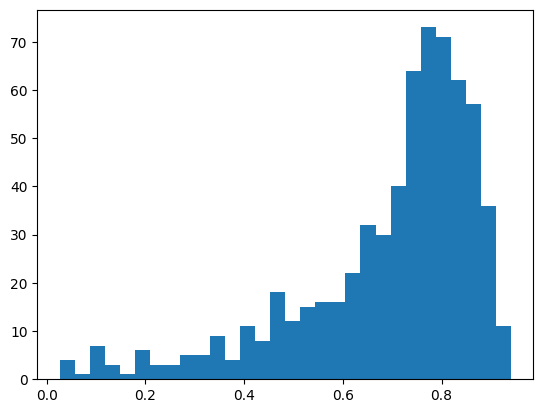

In [37]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [38]:
calibrated_KGES.mean()

0.6361891710137589

In [39]:
np.median(calibrated_KGES)

0.7450685154136463